In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(0, os.environ['PLOT_SETTINGS_DIR'])
import plot_settings
import matplotlib as mpl
import matplotlib.ticker as tk
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24


In [3]:
ttt_df = pd.read_csv('../data/bw_vs_energy_ttt98.csv')
serial_comp = ttt_df.query('not concurrent')[['graph', 'Type', 'blocks', 'tpart','bits', 'factor' ,'Ratio', 'BTT', 'TTT']]
conc_comp = ttt_df.query('concurrent')[['graph', 'Type','blocks', 'tpart','bits', 'factor', 'Ratio', 'BTT', 'TTT']]

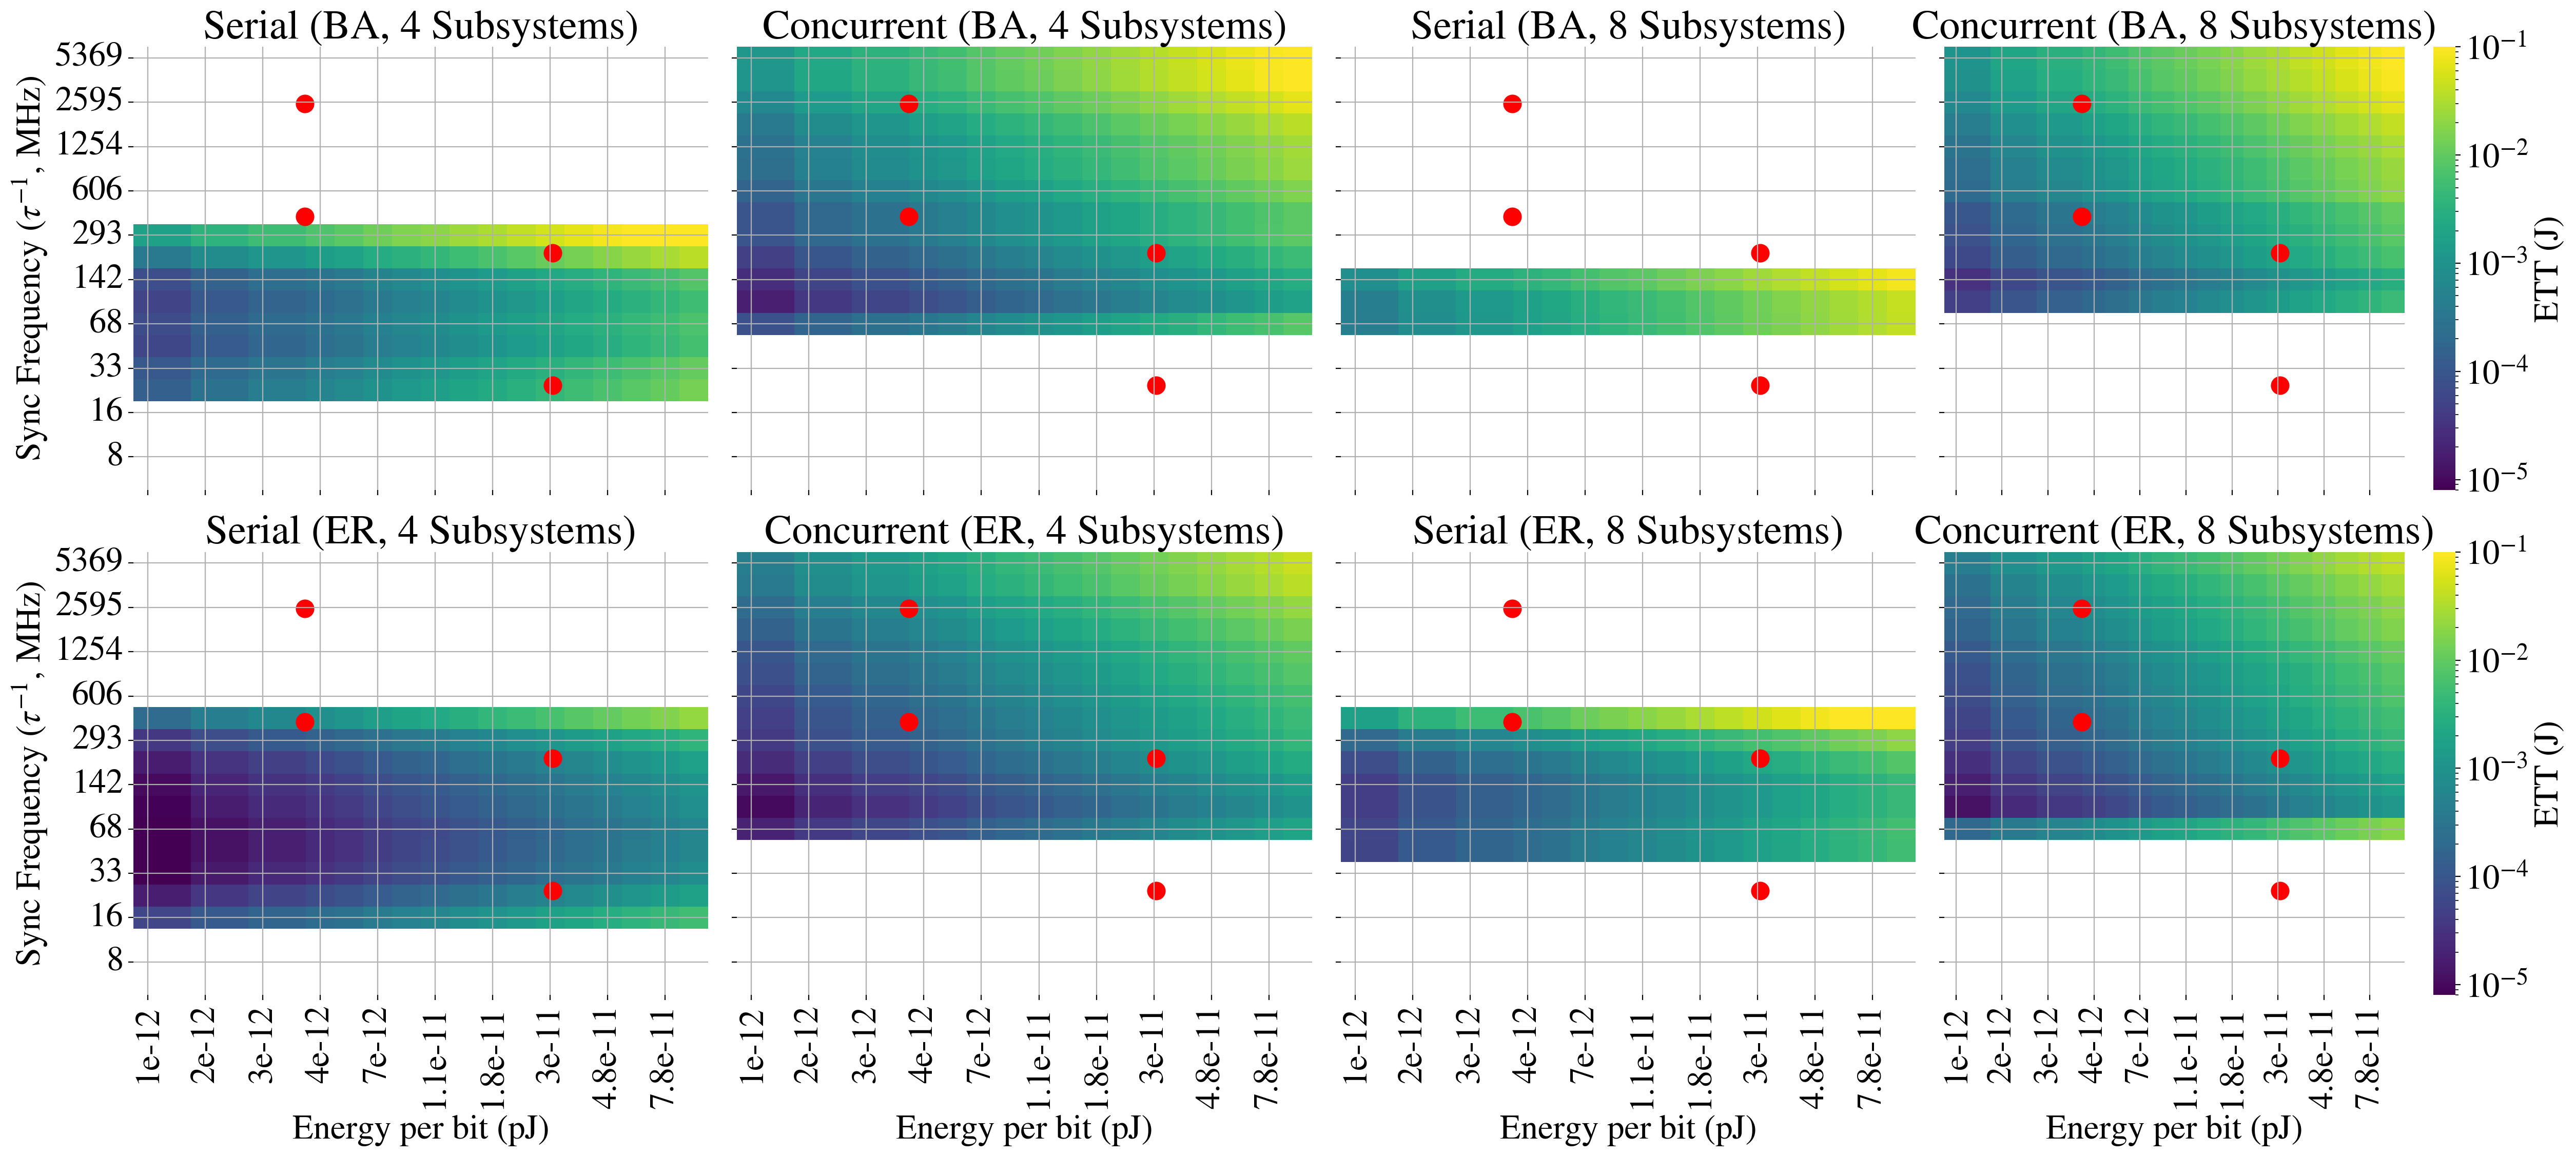

In [4]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 12),
                        gridspec_kw={'wspace': 0.05, 'hspace': 0.14})
ind = 0
comp_y = np.logspace(-12, -10, 20).round(decimals=12)
for (((c,b,t), subdf), ax)  in zip(ttt_df.groupby(['Type', 'blocks', 'concurrent']), axs.flatten()):
    comp_bits = subdf.sort_values(by='tpart').groupby(['tpart']).mean(numeric_only=True).reset_index()
    # comp_bits['tpart'] =comp_bits['tpart'] comp_bits['tpart']
    bandwidth = np.round(np.round(1 / (comp_bits['tpart']) / 1e9, decimals=4) * 1e3).astype(int)
    comp_ene = np.outer(comp_bits['BTT'], comp_y)
    # comp_ene = comp_ene.replace({np.inf: np.nan})
    vals = pd.DataFrame(data=comp_ene, index=bandwidth, columns=comp_y)
    vals = vals.replace({np.inf: np.nan})
    if ind not in {3, 7}:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='viridis', 
                    cbar=False, zorder=-1)
    else:
        sns.heatmap(ax=ax, data=vals, norm=LogNorm(vmin=8e-6, vmax=1e-1), cmap='viridis',  
                    cbar_kws={'label': "ETT (J)"}, zorder=-1)
    if ind not in {0, 4}:
        ax.set_yticklabels(['' for _ in ax.get_yticks()])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Sync Frequency ($\\tau^{-1}$, MHz)')
    if ind < 4:
        ax.set_xticklabels(['' for _ in ax.get_xticks()])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Energy per bit (pJ)')
    if t:
        ax.set_title('Concurrent ({}, {} Subsystems)'.format(c, b))
    else:
        ax.set_title('Serial ({}, {} Subsystems)'.format(c, b))
    ax.grid()
    for bw, label in zip([6553.6, 1024], ['HBM3', 'HBM']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
    #     print(len(bandwidth), ticks)
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(20))
        locx = np.interp([np.log10(3.97e-12)], np.log10(comp_y), np.arange(20))
        ax.scatter(y=(loc), x=locx, linewidth=3, zorder=1, s=100, color='red', marker='o')
        # ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 5), textcoords='offset points', text=label, color='white')
    for bw, label in zip([563.2, 64], ['DDR5', 'DDR2']):
        bw = bw / (1<<30) * 1e9
        hbmmax = bw / (2000) * 1e3
        ticks = ax.get_yticks()
    #     print(len(bandwidth), ticks)
        loc = 20-np.interp([np.log10(hbmmax)], np.log10(bandwidth)[::-1], np.arange(20))
        locx = np.interp([np.log10(34.42e-12)], np.log10(comp_y), np.arange(20))
        ax.scatter(y=(loc), x=locx, linewidth=3, zorder=1, s=100, color='red', marker='o')
        # ax.annotate(xy=(locx[0], loc[0]), xytext=(7, 7), textcoords='offset points', text=label, color='white')
        
    ind+=1
fig.savefig('../figures/energy_update.pdf', bbox_inches='tight')
plt.show()

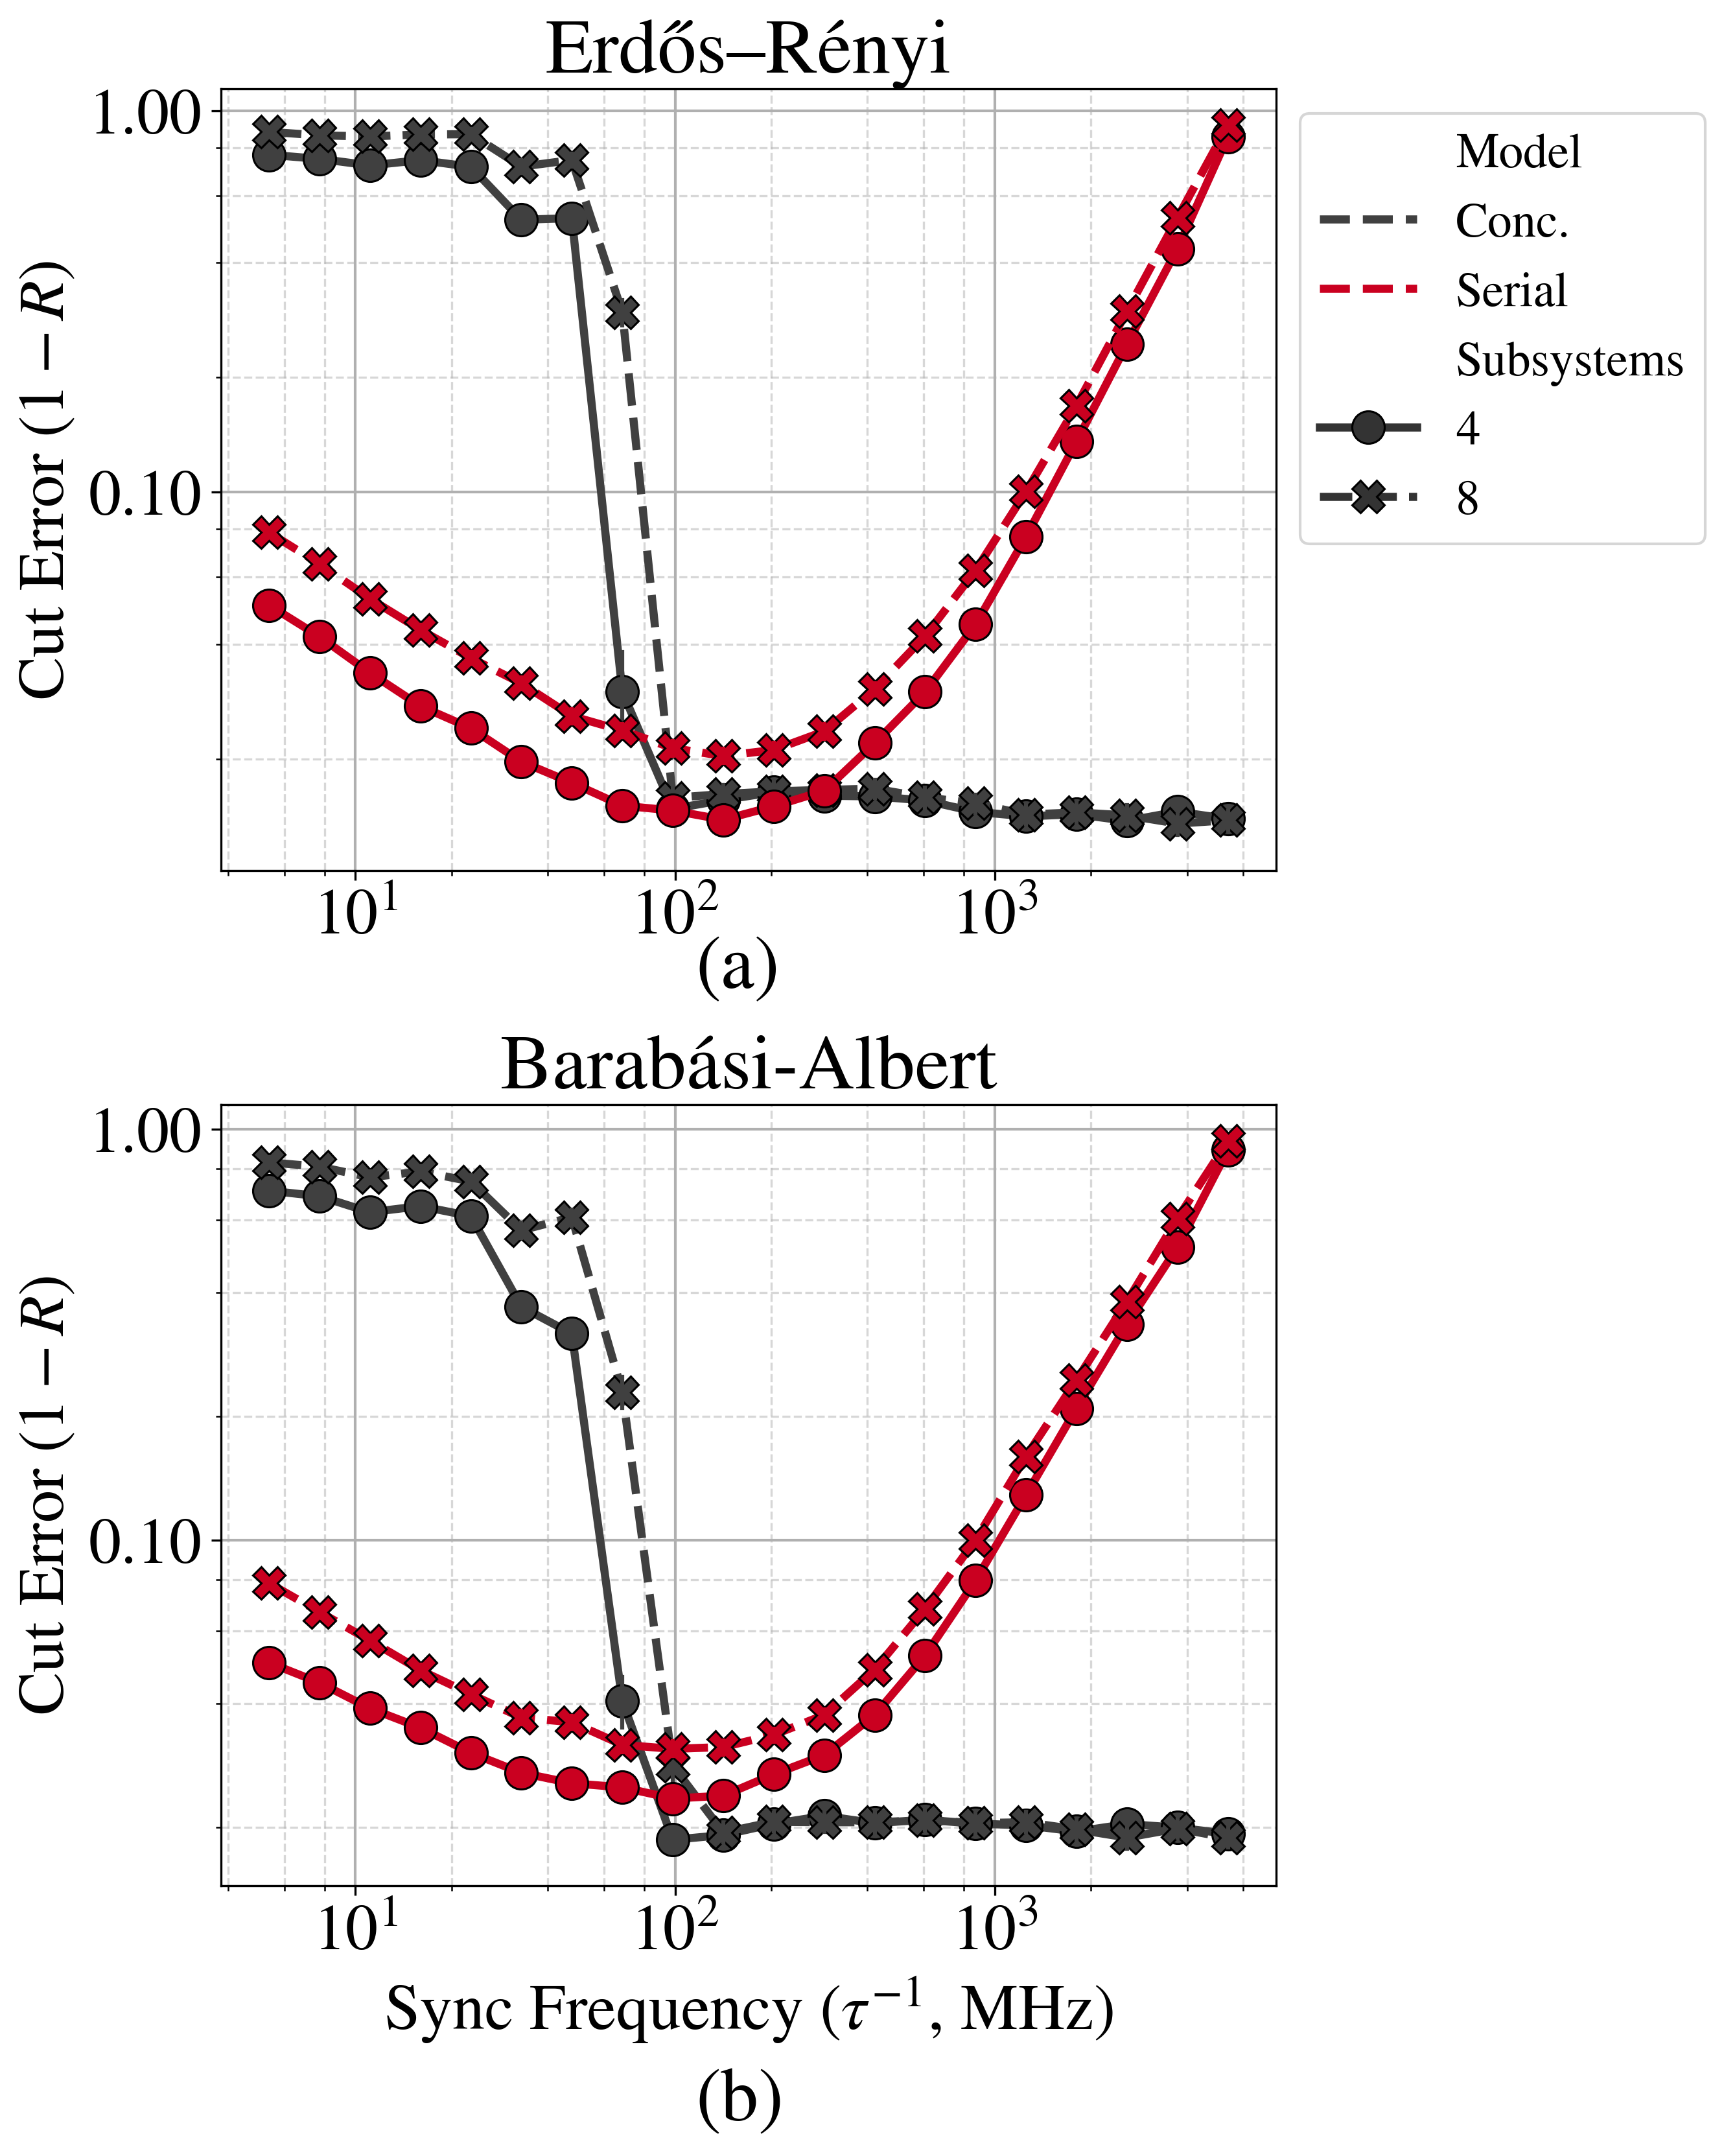

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 12), gridspec_kw={'hspace': .3})
brim_df = pd.read_csv('../data/bw_vs_energy_full.csv').rename(columns={'blocks': 'Subsystems'})
brim_df['Model'] = brim_df['concurrent'].replace({True: 'Conc.', False: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df['Bandwidth'] = 1 / brim_df['tpart'] / 1e6
# brim_df['error'] = brim_df['u'] - -0.7633
line_args = dict(
    y='Inverse Ratio',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
sns.lineplot(ax=axs[0],
                data=brim_df.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df.query('GInd > 30'), 
                **line_args)
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('Erdős–Rényi')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('Cut Error ($1-R$)')
   ax.grid(which='major')
axs[1].legend_ = None
for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.ScalarFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
plt.show()
fig.savefig('../figures/ba_er_cut_error.pdf', bbox_inches='tight')

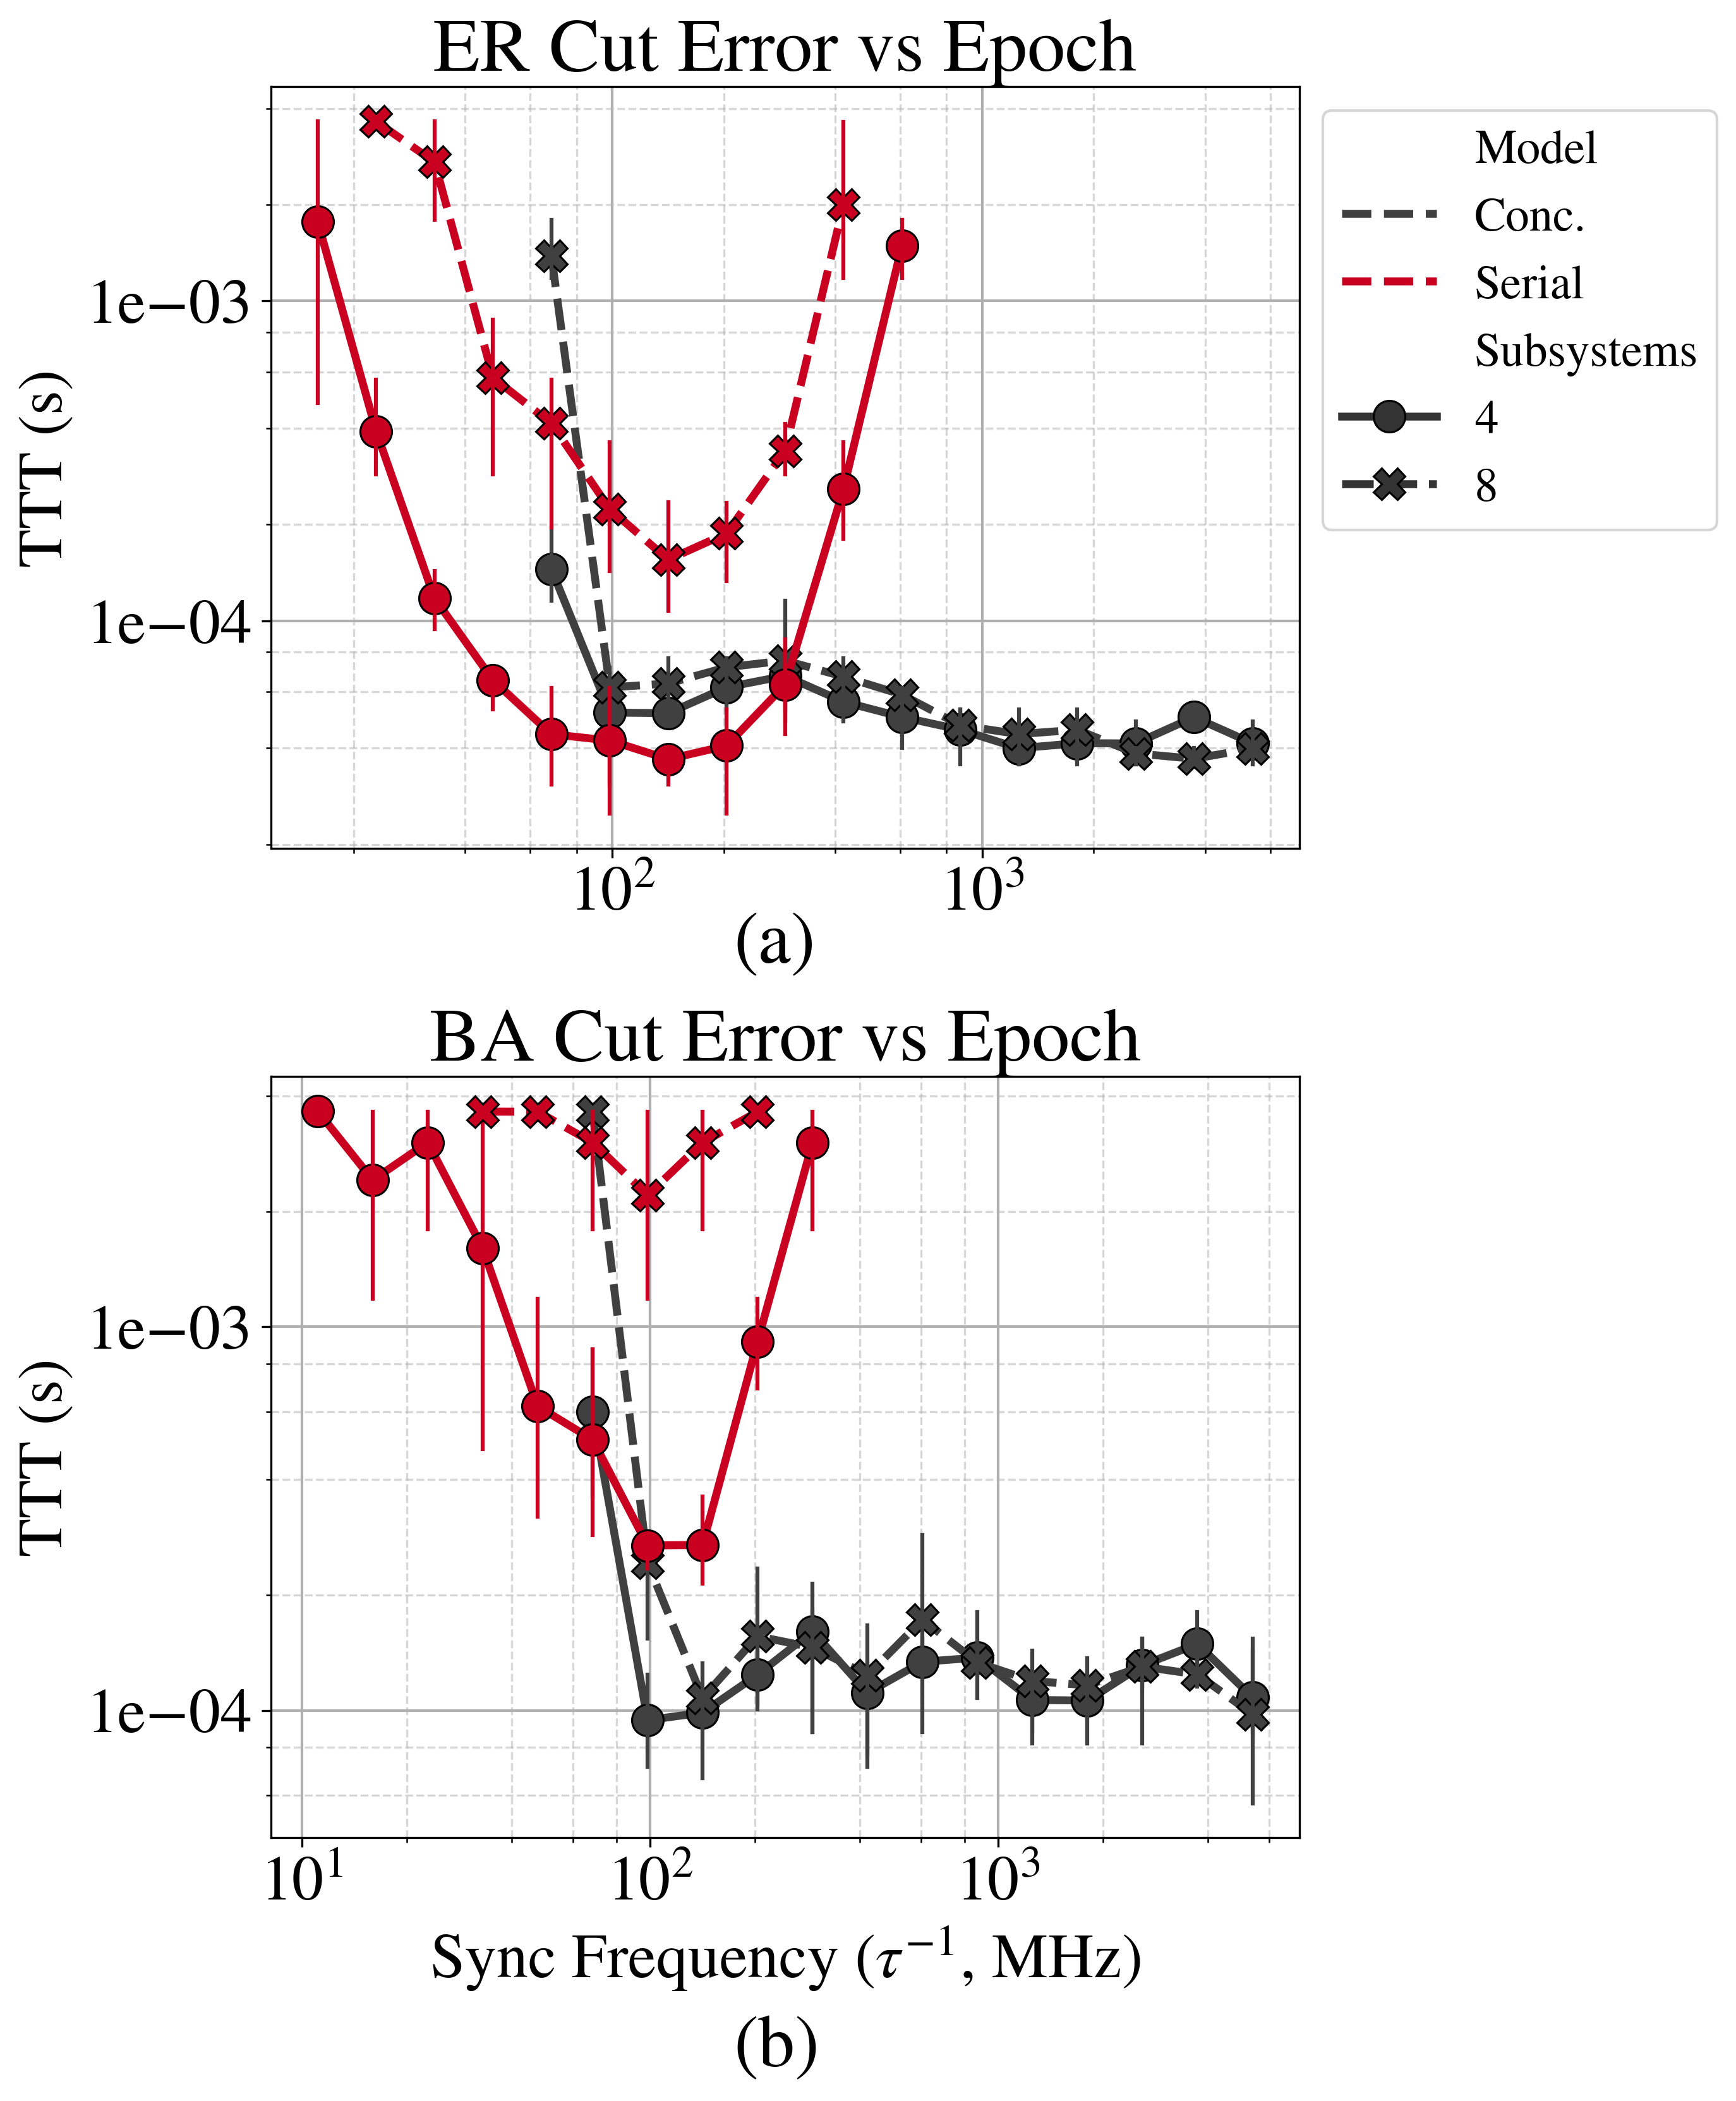

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 12), gridspec_kw={'hspace': .3})
brim_df = pd.read_csv('../data/bw_vs_energy_ttt98.csv').rename(columns={'blocks': 'Subsystems'})
brim_df['Model'] = brim_df['concurrent'].replace({True: 'Conc.', False: 'Serial'})
palette = [ "#404040",
            # "#fdb863",
            # "#f4a582",
            "#ca0020"
            ]
brim_df['Bandwidth'] = 1 / brim_df['tpart'] / 1e6
# brim_df['error'] = brim_df['u'] - -0.7633
line_args = dict(
    y='TTT',
    x='Bandwidth',
    linestyle='--',
    # marker='X',
    markers=True,
    markersize=12,
    style='Subsystems',
    linewidth=3,
    hue='Model',
    markeredgecolor='black',
    err_style='bars',
    palette=palette
)
brim_df = brim_df.sort_values(by=['Model', 'Subsystems'])
sns.lineplot(ax=axs[0],
                data=brim_df.query('GInd < 30'), 
                **line_args)
sns.lineplot(ax=axs[1],
                data=brim_df.query('GInd > 30'), 
                **line_args)
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1,1))

axs[0].set_title('ER Cut Error vs Epoch')
axs[1].set_title('Barabási-Albert')
axs[0].set_xlabel('')
axs[1].set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')

for ax in axs:
   ax.set_xscale('log')
   ax.set_yscale('log')
#    ax.set_xlabel('Sync Frequency ($\\tau^{-1}$, MHz)')
   ax.set_ylabel('TTT (s)')
   ax.grid(which='major')
axs[1].legend_ = None
for ax in axs:

    ax.grid(which='minor', linestyle='--', alpha=0.5)
    ax.grid(which='major', linewidth=1)
    ax.yaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.yaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    ax.xaxis.set_major_locator(tk.LogLocator(base=10, subs=[1]))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10, subs=[2, 4, 6, 8]))
    # ax.yaxis.set_minor_locator(tk.FixedLocator([50, 150, 200]))
    ax.yaxis.set_major_formatter(tk.LogFormatter())
    # ax.yaxis.set_minor_formatter(tk.ScalarFormatter())

axs[0].annotate(text="(a)", xy=(0.45, -0.15), xycoords='axes fraction', fontsize=28)

axs[1].annotate(text="(b)", xy=(0.45, -0.3), xycoords='axes fraction', fontsize=28)
plt.show()
fig.savefig('../figures/ba_er_ttt.pdf', bbox_inches='tight')